# Example of Sequencing Multivariant Oxide Composition (MOC) Data
This notebook shows how MOC data (compiled by mocComplier.py) can be given to [the Sequencer](https://github.com/dalya/Sequencer) so that patterns in the data may be found. While this notebook should allow for a streamlined run of the Sequencer, you must first [install the Sequencer](https://github.com/dalya/Sequencer/blob/master/README.md). It is also recommened to have some [background on the Sequencer](http://sequencer.org/documentation). This notebook is intented to be interacted with (after reading through the sample run), so at a number of points there are variables for the user to modify.

In particular, the notebook will cover:
1. **Preperation:** Loading our data into numpy arrays, and taking a random sample.
1. **Running the Sequencer:** Defining variables, running the Sequencer, and evalulating the "strength" of the identified pattern.
1. **Graphing Inputs and Outputs:** Creating 2D & 3D graphs to visualy compare inputs / outputs, and intpreting differences / similarities.

## Environment Setup
Before we start, required packages must be installed.
Also ensure that you have [installed the Sequencer](https://github.com/dalya/Sequencer/blob/master/README.md).

In [1]:
# Load in relevent Libararies
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.stats import wasserstein_distance
import umap
import sequencer
import random
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

## 1. Preperation
1.1) First, load in relevant data: the two CSV files that were output by mocComplier.py. ```path1``` must be the path to the CSV containing MOC data, and ```path2``` must be the path to the CSV containting the list of numbers that corespond to oxides. Note: both paths must be modified by the user when running on their own local data.

1.2) Second, a random sample of the data will be taken; both the number of samples (```samples```) and the seed for the random sample (```random_seed```) can be modified by the user. The radiance CSV loaded through path1 has ~27,000 rows; so (to drastically improve run time) it can be helpful to take only a sample of the data. 

However, if you dont want to take a random sample, replace cell #1.2 with the following code: 
```
arrMocSample = arrMoc
samples = len(arrMocSample)
```

In [2]:
# 1.1)
# Variables fro the user to modify:
path1 = "/home/matthew/chemCamRepository/programOutputs/mocToSol3644.csv"
path2 = "/home/matthew/chemCamRepository/programOutputs/compoundNums.csv"
samples = 2000
random_seed = 42

In [3]:
# 1.1 cont.)
# Load in the .csv files
arrMoc = np.loadtxt(path1, delimiter=",", dtype=float)
arrCompoundNums = np.loadtxt(path2, delimiter=",", dtype=float)

In [4]:
# 1.2)
# Take random sample of data
np.random.seed(random_seed)
np.random.shuffle(arrMoc)
arrMocSample = arrMoc[:samples, :]

## 2. Running the Sequencer
#### Other Sequencer Inputs
2.1) First, define relevent variables that impact the Sequencer's run: ```estimator_list```, ```scale_list```, and ```output_path```. 
* **Estimator_list:** The Sequencer has four estimators: Euclidean Distance (L2), Kullback-Leibler Divergence (KL), Monge-Wasserstein / Earth Mover Distance (EMD), and Energy Distance (energy). Each of these is a different metric for "looking" at the data. In this example each estimator is being used.
* **Scale_list:**
    * Each list within the scale_list refers to an estimator. Each element within this 2D array is a scale. A scale of n splits the dataset into n parts along (in this case) the ```arrCompoundNums``` axis.
    * This line is comented out because the Sequencer can intelligently choose a scale_list. There are only 9 oxide numbers in this axis/list, so the Sequencer will only "split" the data into 1 part. If there were substantially more oxide numbers the Sequencer would split the data into more parts. 
    * For more context on scales and the important of a multi-scale approach, visit [this notebook](https://github.com/dalya/Sequencer/blob/master/examples/importance_of_multi_scale_approach.ipynb). 
* **output_path:** This is the directory to which the Sequencer will output relevent information and files. One of which, ```distance_matrices.pkl```, allows for the user to re-load in their data instead of re-computing. While this notebook does not cover this topic, please refrence part 4 of [this notebook](https://github.com/dalya/Sequencer/blob/53a8920f1a19f4399338613c2b7b747dac545502/examples/basic_sequencer_functionalities.ipynb) if interested. 

#### Sequencer Outputs
2.2) Next, run the Sequencer and then examine the ```final_elongations``` list. Simply put, the larger the "elongation" value the better - anything over ~35 indicates the presence of a sequence (pattern) in the dataset.
* **Final_elongations:** A list of "elongations" (how much of a pattern is found) in the data at each metric and scale. 

2.3) Lastly, create a new array containing the ordered / sequenced version of the dataset using ```final_sequence```. We will then compare this ordered dataset to the original to see if the Sequencer really did identify any patterns. 
* **Final_sequence:** A list of the original data set's indicies now in the sequenced order.

In [5]:
# 2.1)
# Variables for the user to modify:
estimator_list = ['EMD', 'energy', 'KL', 'L2']
# scale_list = [[1], [1], [1], [1]]
output_path = "/home/matthew/chemCamRepository/outputDirectoryMocEx"

In [6]:
# 2.2)
# Runs The Sequencer (Note: this could take a while)
seq=sequencer.Sequencer(arrCompoundNums, arrMocSample, estimator_list) #, scale_list=scale_list
final_elongation, final_sequence = seq.execute(output_path,
                                               to_average_N_best_estimators=True, 
                                               number_of_best_estimators=2,
                                               to_use_parallelization=True) 

# Print elongations for each estimator and scale (the bigger the better)
print("\n\nresulting elongation for the Sequencer: ", final_elongation)
estimator_list, scale_list, elongation_list = seq.return_elongation_of_weighted_products_all_metrics_and_scales()
print("intermediate elongations for the different metrics and scales:")
for i in range(len(estimator_list)):
    print("metric=%s, scale=%s, elongation: %s" % (estimator_list[i], scale_list[i], np.round(elongation_list[i], 2)))

Parallelization is ON. Number of cores: 8
calculating the distance matrices for estimator: EMD, scale: 1
finished calculating this distance matrix list, it took: 44.84426832199097 seconds
calculating the distance matrices for estimator: energy, scale: 1
finished calculating this distance matrix list, it took: 46.88057565689087 seconds
calculating the distance matrices for estimator: KL, scale: 1
finished calculating this distance matrix list, it took: 50.80464267730713 seconds
calculating the distance matrices for estimator: L2, scale: 1
finished calculating this distance matrix list, it took: 15.525351285934448 seconds
dumped the distance matrix dictionaries to the file: /home/matthew/chemCamRepository/outputDirectoryMocEx/distance_matrices.pkl
strating to sequence the different scales and estimators
in estimator: EMD, scale: 1
in estimator: energy, scale: 1
in estimator: KL, scale: 1
in estimator: L2, scale: 1
dumped the elongations to the file: /home/matthew/chemCamRepository/output

/home/matthew/.local/lib/python3.10/site-packages/sequencer/sequencer_.py:1025: RuntimeWarning: divide by zero encountered in true_divide
  distance_matrix = 1.0 / proximity_matrix_copy


dumped the sparse distance matrix to the file: <_io.BufferedWriter name='/home/matthew/chemCamRepository/outputDirectoryMocEx/sparse_distance_matrix.pkl'>
dumped the final sequences and elongation to the file: <_io.BufferedWriter name='/home/matthew/chemCamRepository/outputDirectoryMocEx/final_products.pkl'>


resulting elongation for the Sequencer:  27.575648000000005
intermediate elongations for the different metrics and scales:
metric=EMD, scale=1, elongation: 27.42
metric=energy, scale=1, elongation: 27.58
metric=KL, scale=1, elongation: 19.05
metric=L2, scale=1, elongation: 20.17


In [7]:
# 2.3)
# Create new array - the ordered (sequenced) version of the data
arrMocSampleOrdered = arrMocSample[final_sequence, :]

## 3. Graphing Inputs and Outputs
3.1) The following variables are intended to be modified by the user: 
* **Save:** Do you want to save a local copy of the graphs? True / False
* **Name2D:** The file name of the 2D graph, if you save the graph. Include .png or other format at the end.
* **Name3D:** The file name of the 3D graph, if you save the graph. Include .png or other format at the end. 
* **Resolution:** This is how detailed the saved image will be. 300 = 5k x 2.5k pixles. 
* **Scale:** This is how "granular" the graph is where higher values = more detail.

3.2) Create a 2D or "birds eye view" graph of the data. 
See annotations below image to help with interpretaion. 

3.3) Create a 3D or side view graph of the data. 
See annotations below image to help with interpretaion. 

3.4) Unlike the 2D and 3D graphs of parts 3.2 and 3.3, the graphs created in this part allow for percision comparison between a few different oxide's compositions. These graphs have the same **Save**, **Name**, and **Resolution** variables as parts 3.2 and 3.3, however they have a few addition variables intended for the user to modify:
* **ListOxideIndex:** A list of the index of the Major Oxides (SiO2, TiO2, Al2O3, FeOT, MgO, CaO, Na2O, K2O, and MnO) the user wishes to include in the graph.  
* **ListLabels:** A list of the Oxide / Element names for each of the scatter plot graphs that will be produced. 
* **ListColors:** A list of the colors of the graphs, each coresponding by index to their respective Oxide.

In [8]:
# 3.1)
# Variables for the user to modify 
save = False # Do you want to save the graphs produced?
name2D = 'name2D.png' # Name of the 2D graph
name3D = 'name3D.png' # Name of the 3D graph
resolution = 300 # Resolution of graphs (300, 600, or 1200) are standard
scale = 20 # Masure of how granular graph is

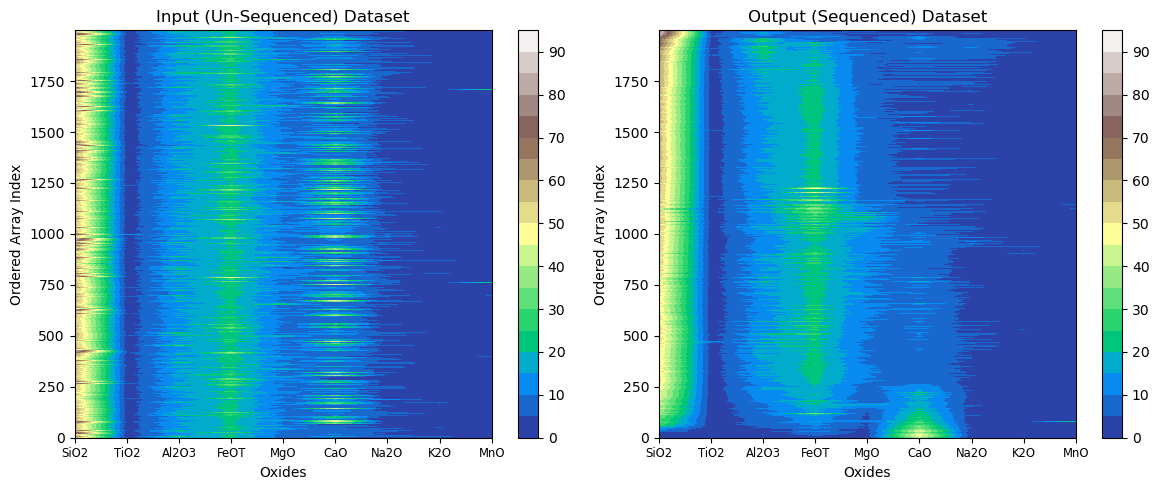

In [9]:
# 3.1)
# Following code creates a 2D comparision graph
arrayIndex = np.linspace(0, samples-1, num=samples, dtype=int)
arrOxides = ['SiO2', 'TiO2', 'Al2O3', 'FeOT', 'MgO', 'CaO', 'Na2O', 'K2O', 'MnO']

# Left Graph
######################################################
plt.figure(1, figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Input (Un-Sequenced) Dataset")
plt.contourf(arrMocSample, scale, cmap='terrain')
plt.xticks(range(len(arrOxides)), arrOxides, size='small')
plt.xlabel("Oxides")
plt.ylabel("Ordered Array Index")
plt.colorbar()

# Right Graph
######################################################
plt.subplot(1, 2, 2)
plt.title("Output (Sequenced) Dataset")
plt.contourf(arrMocSampleOrdered, scale, cmap='terrain')
plt.xticks(range(len(arrOxides)), arrOxides, size='small')
plt.xlabel("Oxides")
plt.ylabel("Ordered Array Index")
plt.colorbar()
 
plt.tight_layout()
if save == True:
    plt.savefig(name2D, bbox_inches='tight', dpi=resolution)

### 3.2) Interpretaion of 2D Graph
#### The Sequencer in Context
* The Sequencer essenally rearranges rows so that similar data is next to each other, this can help identify patterns. 
* Each row in these graphs takes the SiO2, TiO2, Al2O3, FeOT, MgO, CaO, Na2O, K2O and MnO values from a row in a moc\*.csv file. Each row is one prediction of a rock surface / soil sample's oxide composition.
* We are "looking down" on all of these oxide predition rows from a bird's eye view.

#### Understanding the Graphs
While these images are 2D they represents information in three "dimentions":
* X: Oxides
* Y: Un-Ordered & Ordered Array Index
* Color: Percent Composition of the sample

Note: It is important to remember that this data is predicted (not actual) concentrations of oxides in the sample.  

#### We can conclude:
* SiO2, FeOT, Al2O3, and MgO where the most common oxides in the samples, appearing in ~98%. 
    * SiO2 comprised ~40% to ~90% of the sample
    * FeOT comprised ~20% of the sample on average.
    * Al2O3 comprised ~12% of the sample on average.
    * MgO comprised ~8% of the sample on average. 
* CaO also appeared frequently; however, its concentration seems inversly corelated to the oxides mentioned above.
    * When CaO is at its higest concentration (~40%), SiO2, FeOT, Al2O3, and MgO all have conenentrations of ~0%.
    * When SiO2 is at its highest concentration (\~90%), CaO is at its lowest conenctration (\~5% on average). 
* TiO2, Na2O, K2O, and MnO all appeared in-frequently with little to no pattern to be dicerned.
    * However, Na2O and K2O appear to be at their highest concentration (~5%) when CaO is at its lowest / Si is nearing its highest concentration. 

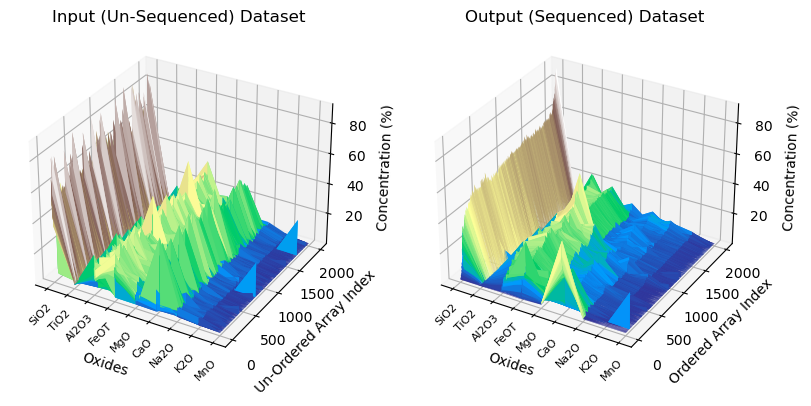

In [10]:
# 3.3)
# Following code creates a 3D comparison graph
y = np.linspace(0, samples-1, num=samples, dtype=int)
x = arrCompoundNums
X, Y = np.meshgrid(x, y)
fig = plt.figure(figsize=plt.figaspect(0.5))
arrOxides = ['SiO2', 'TiO2', 'Al2O3', 'FeOT', 'MgO', 'CaO', 'Na2O', 'K2O', 'MnO']

# Left Graph
######################################################
Z = arrMocSample
ax = fig.add_subplot(121, projection='3d')
p = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                 cmap='terrain', linewidth=0, antialiased=True)
ax.set_xticks(x)
ax.set_xticklabels(arrOxides, rotation=45, rotation_mode="anchor", fontsize=8)
ax.set_title('Input (Un-Sequenced) Dataset');
plt.xlabel("Oxides")
plt.ylabel("Un-Ordered Array Index")
ax.set_zlabel("Concentration (%)", rotation=90)

# Right Graph
######################################################
Z = arrMocSampleOrdered
ax = fig.add_subplot(122, projection='3d')
p = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                 cmap='terrain', linewidth=0, antialiased=True)
ax.set_xticks(x)
ax.set_xticklabels(arrOxides, rotation=45, rotation_mode="anchor", fontsize=8)
ax.set_title('Output (Sequenced) Dataset');
plt.xlabel("Oxides")
plt.ylabel("Ordered Array Index")
ax.set_zlabel("Concentration (%)", rotation=90)

if save == True:
    plt.savefig(name, bbox_inches='tight', dpi=resolution)

### 3.2) Interpretaion of 2D Graph
#### The Sequencer in Context
* The Sequencer essenally rearranges rows so that similar data is next to each other, this can help identify patterns. 
* Each row in these graphs takes the SiO2, TiO2, Al2O3, FeOT, MgO, CaO, Na2O, K2O and MnO values from a row in a moc\*.csv file. Each row is one prediction of a rock surface / soil sample's oxide composition.
* We are "looking down" on all of these oxide predition rows from a bird's eye view.

#### Understanding the Graphs
These images are 3D but could present information in another dimention (their color); however, both color and vertical elevation represent the same information:
* X: Oxides (labels appear a little shifted to the right of their coresponding "tick") 
* Y: Un-Ordered & Ordered Array Index
* Z: Percent Composition of the sample
* Color: Percent Composition of the sample

Note: It is important to remember that this data is predicted (not actual) concentrations of oxides in the sample.  

#### We can conclude:
* SiO2, FeOT, Al2O3, and MgO where the most common oxides in the samples, appearing in ~98%. 
    * SiO2 comprised ~40% to ~90% of the sample
    * FeOT comprised ~20% of the sample on average.
    * Al2O3 comprised ~12% of the sample on average.
    * MgO comprised ~8% of the sample on average. 
* CaO also appeared frequently; however, its concentration seems inversly corelated to the oxides mentioned above.
    * When CaO is at its higest concentration (~40%), SiO2, FeOT, Al2O3, and MgO all have conenentrations of ~0%.
    * When SiO2 is at its highest concentration (\~90%), CaO is at its lowest conenctration (\~5% on average). 
* TiO2, Na2O, K2O, and MnO all appeared in-frequently with little to no pattern to be dicerned.
    * However, Na2O and K2O appear to be at their highest concentration (~5%) when CaO is at its lowest / Si is nearing its highest concentration. 

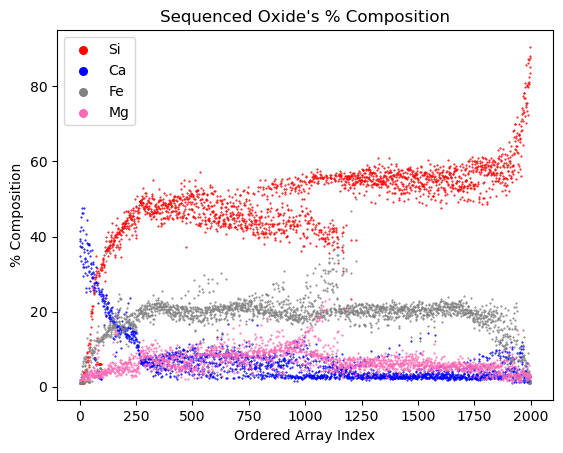

In [11]:
# 3.4)
# Variables for the user to modify 
#########################################################
listOxideIndex = [0, 5, 3, 4]
listLabels = ['Si', 'Ca', 'Fe', 'Mg']
listColors = ['Red', 'Blue', 'Grey', 'HotPink']
save = False
name = 'name.png'
resolution = 600
#########################################################

x = np.arange(0, samples)
arrMocSamplesOrderedGraph = arrMocSampleOrdered.transpose()
for i in range(len(listOxideIndex)):
    y = arrMocSamplesOrderedGraph[listOxideIndex[i]]
    plt.scatter(x, y, s=0.25, color = listColors[i], label = listLabels[i])
lgnd = plt.legend(loc="upper left", scatterpoints=1, fontsize=10)
for i in range(len(listOxideIndex)):
    lgnd.legendHandles[i]._sizes = [30]
plt.title('Sequenced Oxide\'s % Composition');
plt.xlabel("Ordered Array Index")
plt.ylabel("% Composition")

if save == True:
    plt.savefig(name, dpi=resolution)